# Optimal Growth II: Time Iteration

## Contents

- [Optimal Growth II: Time Iteration](#Optimal-Growth-II:-Time-Iteration)  
  - [Overview](#Overview)  
  - [The Euler Equation](#The-Euler-Equation)  
  - [Comparison with Value Function Iteration](#Comparison-with-Value-Function-Iteration)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

In this lecture we’ll continue our [earlier study](https://lectures.quantecon.org/py/optgrowth.html) of the stochastic optimal growth model

In that lecture we solved the associated discounted dynamic programming problem using value function iteration

The beauty of this technique is its broad applicability

With numerical problems, however, we can often attain higher efficiency in specific
applications by deriving methods that are carefully tailored to the application at hand

The stochastic optimal growth model has plenty of structure to exploit for this purpose,
especially when we adopt some concavity and smoothness assumptions over primitives

We’ll use this structure to obtain an **Euler equation**  based method that’s more efficient
than value function iteration for this and some other closely related applications

In a [subsequent lecture](https://lectures.quantecon.org/py/egm_policy_iter.html) we’ll see that the numerical implementation
part of the Euler equation method can be further adjusted to obtain even more efficiency

Let’s start with some imports

In [1]:
import numpy as np
import quantecon as qe
from interpolation import interp
from numba import njit, prange
from quantecon.optimize import brentq
from quantecon.optimize.scalar_maximization import brent_max
import matplotlib.pyplot as plt
%matplotlib inline

## The Euler Equation

Let’s take the model set out in [the stochastic growth model lecture](https://lectures.quantecon.org/py/optgrowth.html) and add the assumptions that

1. $ u $ and $ f $ are continuously differentiable and strictly concave  
1. $ f(0) = 0 $  
1. $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  
1. $ \lim_{k \to 0} f'(k) = \infty $ and $ \lim_{k \to \infty} f'(k) = 0 $  


The last two conditions are usually called **Inada conditions**

Recall the Bellman equation


<a id='equation-cpi-fpb30'></a>
$$
v^*(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
    \right\}
\quad \text{for all} \quad
y \in \mathbb R_+ \tag{1}
$$

Let the optimal consumption policy be denoted by $ \sigma^* $

We know that $ \sigma^* $ is a $ v^* $ greedy policy, so that $ \sigma^*(y) $ is the maximizer in [(1)](#equation-cpi-fpb30)

The conditions above imply that

- $ \sigma^* $ is the unique optimal policy for the stochastic optimal growth model  
- the optimal policy is continuous, strictly increasing and also **interior**, in the sense that $ 0 < \sigma^*(y) < y $ for all strictly positive $ y $, and  
- the value function is strictly concave and continuously differentiable, with  



<a id='equation-cpi-env'></a>
$$
(v^*)'(y) = u' (\sigma^*(y) ) := (u' \circ \sigma^*)(y) \tag{2}
$$

The last result is called the **envelope condition** due to its relationship with the [envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem)

To see why [(2)](#equation-cpi-env) might be valid, write the Bellman equation in the equivalent
form

$$
v^*(y) = \max_{0 \leq k \leq y}
    \left\{
        u(y-k) + \beta \int v^*(f(k) z) \phi(dz)
    \right\},
$$

differentiate naively with respect to $ y $,  and then  evaluate at the optimum

Section 12.1 of [EDTC](http://johnstachurski.net/edtc.html) contains full proofs of these results, and closely related discussions can be found in many other texts

Differentiability of the value function and interiority of the optimal policy
imply that optimal consumption satisfies the first order condition associated
with [(1)](#equation-cpi-fpb30), which is


<a id='equation-cpi-foc'></a>
$$
u'(\sigma^*(y)) = \beta \int (v^*)'(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z \phi(dz) \tag{3}
$$

Combining [(2)](#equation-cpi-env) and the first-order condition [(3)](#equation-cpi-foc) gives the famous **Euler equation**


<a id='equation-cpi-euler'></a>
$$
(u'\circ \sigma^*)(y)
= \beta \int (u'\circ \sigma^*)(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z \phi(dz) \tag{4}
$$

We can think of the Euler equation as a functional equation


<a id='equation-cpi-euler-func'></a>
$$
(u'\circ \sigma)(y)
= \beta \int (u'\circ \sigma)(f(y - \sigma(y)) z) f'(y - \sigma(y)) z \phi(dz) \tag{5}
$$

over interior consumption policies $ \sigma $, one solution of which is the optimal policy $ \sigma^* $

Our aim is to solve the functional equation [(5)](#equation-cpi-euler-func) and hence obtain $ \sigma^* $

### The Coleman-Reffett Operator

Recall the Bellman operator


<a id='equation-fcbell20-coleman'></a>
$$
Tw(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int w(f(y - c) z) \phi(dz)
\right\} \tag{6}
$$

Just as we introduced the Bellman operator to solve the Bellman equation, we
will now introduce an operator over policies to help us solve the Euler
equation

This operator $ K $ will act on the set of all $ \sigma \in \Sigma $
that are continuous, strictly increasing and interior (i.e., $ 0 < \sigma(y) < y $ for all strictly positive $ y $)

Henceforth we denote this set of policies by $ \mathscr P $

1. The operator $ K $ takes as its argument a $ \sigma \in \mathscr P $ and  
1. returns a new function $ K\sigma $,  where $ K\sigma(y) $ is the $ c \in (0, y) $ that solves  



<a id='equation-cpi-coledef'></a>
$$
u'(c)
= \beta \int (u' \circ \sigma) (f(y - c) z ) f'(y - c) z \phi(dz) \tag{7}
$$

We call this operator the **Coleman-Reffett operator** to acknowledge the work of
[[Col90]](https://lectures.quantecon.org/py/zreferences.html#coleman1990) and [[Ref96]](https://lectures.quantecon.org/py/zreferences.html#reffett1996)

In essence, $ K\sigma $ is the consumption policy that the Euler equation tells
you to choose today when your future consumption policy is $ \sigma $

The  important thing to note about $ K $ is that, by
construction, its fixed points coincide with solutions to the functional
equation [(5)](#equation-cpi-euler-func)

In particular, the optimal policy $ \sigma^* $ is a fixed point

Indeed, for fixed $ y $, the value $ K\sigma^*(y) $ is the $ c $ that
solves

$$
u'(c)
= \beta \int (u' \circ \sigma^*) (f(y - c) z ) f'(y - c) z \phi(dz)
$$

In view of the Euler equation, this is exactly $ \sigma^*(y) $

### Is the Coleman-Reffett Operator Well Defined?

In particular, is there always a unique $ c \in (0, y) $ that solves
[(7)](#equation-cpi-coledef)?

The answer is yes, under our assumptions

For any $ \sigma \in \mathscr P $, the right side of [(7)](#equation-cpi-coledef)

- is continuous and strictly increasing in $ c $ on $ (0, y) $  
- diverges to $ +\infty $ as $ c \uparrow y $  


The left side of [(7)](#equation-cpi-coledef)

- is continuous and strictly decreasing in $ c $ on $ (0, y) $  
- diverges to $ +\infty $ as $ c \downarrow 0 $  


Sketching these curves and using the information above will convince you that they cross exactly once as $ c $ ranges over $ (0, y) $

With a bit more analysis, one can show in addition that $ K \sigma \in \mathscr P $
whenever $ \sigma \in \mathscr P $

## Comparison with Value Function Iteration

How does Euler equation time iteration compare with value function iteration?

Both can be used to compute the optimal policy, but is one faster or more
accurate?

There are two parts to this story

First, on a theoretical level, the two methods are essentially isomorphic

In particular, they converge at  the same rate

We’ll prove this in just a moment

The other side to the story is the accuracy of the numerical implementation

It turns out that, once we actually implement these two routines, time iteration is more accurate than value function iteration

More on this below

### Equivalent Dynamics

Let’s talk about the theory first

To explain the connection between the two algorithms, it helps to understand
the notion of equivalent dynamics

(This concept is very helpful in many other contexts as well)

Suppose that we have a function $ g \colon X \to X $ where $ X $ is a given set

The pair $ (X, g) $ is sometimes called a **dynamical system** and we
associate it with trajectories of the form

$$
x_{t+1} = g(x_t), \qquad x_0 \text{ given}
$$

Equivalently, $ x_t = g^t(x_0) $, where $ g $ is the $ t $-th
composition of $ g $ with itself

Here’s the picture

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/col_pol_composition.png" style="width:40%;height:40%">

  
Now let another function $ h \colon Y \to Y $ where $ Y $ is another set

Suppose further that

- there exists a bijection $ \tau $ from $ X $ to $ Y $  
- the two functions **commute** under $ \tau $, which is to say that
  $ \tau(g(x)) = h (\tau(x)) $ for all $ x \in X $  


The last statement can be written more simply as

$$
\tau \circ g = h \circ \tau
$$

or, by applying $ \tau^{-1} $ to both sides


<a id='equation-cpi-ghcom'></a>
$$
g = \tau^{-1} \circ h \circ \tau \tag{8}
$$

Here’s a commutative diagram that illustrates

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/col_pol_bij1.png" style="width:20%;height:20%">

  
Here’s a similar figure that traces out the action of the maps on a point
$ x \in X $

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/col_pol_bij2.png" style="width:20%;height:20%">

  
Now, it’s easy to check from [(8)](#equation-cpi-ghcom) that $ g^2 = \tau^{-1} \circ h^2 \circ \tau $ holds

In fact, if you like proofs by induction, you won’t have trouble showing that

$$
g^n = \tau^{-1} \circ h^n \circ \tau
$$

is valid for all $ n $

What does this tell us?

It tells us that the following are equivalent

- iterate $ n $ times with $ g $, starting at $ x $  
- shift $ x $ to $ Y $ using $ \tau $,  iterate $ n $ times with $ h $ starting at $ \tau(x) $, and shift the result $ h^n(\tau(x)) $ back to $ X $ using $ \tau^{-1} $  


We end up with exactly the same object

### Back to Economics

Have you guessed where this is leading?

What we’re going to show now is that the operators $ T $ and $ K $
commute under a certain bijection

The implication is that they have exactly the same rate of convergence

To make life a little easier, we’ll assume in the following analysis (although not
always in our applications) that $ u(0) = 0 $

#### A Bijection

Let $ \mathscr V $ be all strictly concave, continuously differentiable functions $ v $ mapping $ \mathbb R_+ $ to itself and satisfying $ v(0) = 0 $ and $ v'(y) > u'(y) $ for all positive $ y $

For $ v \in \mathscr V $ let

$$
M v := h \circ v' \qquad \text{where } h := (u')^{-1}
$$

Although we omit details, $ \sigma := M v $ is actually the unique
$ v $-greedy policy

- See proposition 12.1.18 of [EDTC](http://johnstachurski.net/edtc.html)  


It turns out that $ M $ is a bijection from $ \mathscr V $ to $ \mathscr P $

A (solved) exercise below asks you to confirm this

#### Commutative Operators

It is an additional solved exercise (see below) to show that $ T $ and $ K $ commute under $ M $, in the sense that


<a id='equation-cpi-ed-tk'></a>
$$
M \circ T = K \circ M \tag{9}
$$

In view of the preceding discussion, this implies that

$$
T^n = M^{-1} \circ K^n \circ M
$$

Hence, $ T $ and $ K $ converge at exactly the same rate!

## Implementation

We’ve just shown that the operators $ T $ and $ K $ have the same rate of convergence

However, it turns out that, once numerical approximation is taken into account, significant differences arises

In particular, the image of policy functions under $ K $ can be calculated faster and with greater accuracy than the image of value functions under $ T $

Our intuition for this result is that

- the Coleman-Reffett operator exploits more information because it uses first order and envelope conditions  
- policy functions generally have less curvature than value functions, and hence admit more accurate approximations based on grid point information  


First we’ll store the parameters of the model is a class `OptimalGrowthModel`

In [2]:
class OptimalGrowthModel:

    def __init__(self,
                 f,
                 f_prime,
                 u,
                 u_prime,
                 β=0.96,
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=200,
                 shock_size=250):

        self.β, self.μ, self.s = β, μ, s
        self.f, self.u = f, u
        self.f_prime, self.u_prime = f_prime, u_prime

        self.y_grid = np.linspace(1e-5, grid_max, grid_size)       # Set up grid
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks

Here’s some code that returns the Coleman-Reffett operator, $ K $

In [3]:
def time_operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Coleman-Reffett operator.

    Here og is an instance of OptimalGrowthModel.
    """
    β = og.β
    f, u = og.f, og.u
    f_prime, u_prime = og.f_prime, og.u_prime
    y_grid, shocks = og.y_grid, og.shocks

    @njit
    def objective(c, σ, y):
        """
        The right hand side of the operator
        """
        # First turn w into a function via interpolation
        σ_func = lambda x: interp(y_grid, σ, x)
        vals = u_prime(σ_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
        return u_prime(c) - β * np.mean(vals)

    @njit(parallel=parallel_flag)
    def K(σ):
        """
        The Coleman-Reffett operator
        """
        σ_new = np.empty_like(σ)
        for i in prange(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal c at y
            c_star = brentq(objective, 1e-10, y-1e-10, args=(σ, y))[0]
            σ_new[i] = c_star

        return σ_new

    return K

It has some similarities to the code for the Bellman operator in our [optimal growth lecture](https://lectures.quantecon.org/py/optgrowth.html)

For example, it evaluates integrals by Monte Carlo and approximates functions using linear interpolation

Here’s that Bellman operator code again, which needs to be executed because we’ll use it in some tests below

In [4]:
def operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Bellman operator, as well as
    a function that computes greedy policies.
    
    Here og is an instance of OptimalGrowthModel.
    """

    f, u, β = og.f, og.u, og.β
    y_grid, shocks = og.y_grid, og.shocks

    @njit
    def objective(c, v, y):
        """
        The right hand side of the Bellman equation
        """
        # First turn v into a function via interpolation
        v_func = lambda x: interp(y_grid, v, x)
        return u(c) + β * np.mean(v_func(f(y - c) * shocks))

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """
        v_new = np.empty_like(v)
        for i in prange(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal v at y
            v_max = brent_max(objective, 1e-10, y, args=(v, y))[1]  
            v_new[i] = v_max
        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        σ = np.empty_like(v)
        for i in range(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal c at y
            c_max = brent_max(objective, 1e-10, y, args=(v, y))[0]  
            σ[i] = c_max
        return σ

    return T, get_greedy

### Testing on the Log / Cobb–Douglas case

As we [did for value function iteration](https://lectures.quantecon.org/py/optgrowth.html), let’s start by
testing our method in the presence of a model that does have an analytical
solution

First we generate an instance of `OptimalGrowthModel` and return the corresponding
Coleman-Reffett operator

In [5]:
α = 0.3

@njit
def f(k):
    "Deterministic part of production function"
    return k**α

@njit
def f_prime(k):
    return α * k**(α - 1)

og = OptimalGrowthModel(f=f, f_prime=f_prime,
                        u=np.log, u_prime=njit(lambda x: 1/x))

K = time_operator_factory(og)

As a preliminary test, let’s see if $ K \sigma^* = \sigma^* $, as implied by the
theory

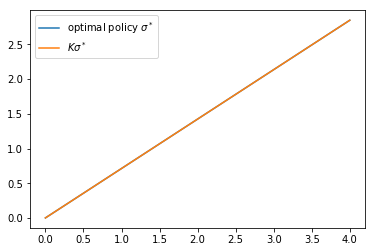

In [6]:
@njit
def σ_star(y, α, β):
    "True optimal policy"
    return (1 - α * β) * y

y_grid, β = og.y_grid, og.β
σ_star_new = K(σ_star(y_grid, α, β))

fig, ax = plt.subplots()
ax.plot(y_grid, σ_star(y_grid, α, β), label="optimal policy $\sigma^*$")
ax.plot(y_grid, σ_star_new, label="$K\sigma^*$")

ax.legend()
plt.show()

We can’t really distinguish the two plots, so we are looking good, at least
for this test

Next let’s try iterating from an arbitrary initial condition and see if we
converge towards $ \sigma^* $

The initial condition we’ll use is the one that eats the whole pie: $ \sigma(y) = y $

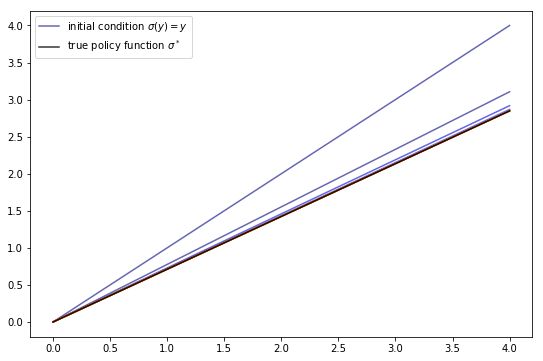

In [7]:
n = 15
σ = y_grid.copy()  # Set initial condition
fig, ax = plt.subplots(figsize=(9, 6))
lb = 'initial condition $\sigma(y) = y$'
ax.plot(y_grid, σ, color=plt.cm.jet(0), alpha=0.6, label=lb)

for i in range(n):
    σ = K(σ)
    ax.plot(y_grid, σ, color=plt.cm.jet(i / n), alpha=0.6)

lb = 'true policy function $\sigma^*$'
ax.plot(y_grid, σ_star(y_grid, α, β), 'k-', alpha=0.8, label=lb)
ax.legend()

plt.show()

We see that the policy has converged nicely, in only a few steps

Now let’s compare the accuracy of iteration between the operators

We’ll generate

1. $ K^n \sigma $ where $ \sigma(y) = y $  
1. $ (M \circ T^n \circ M^{-1}) \sigma $ where $ \sigma(y) = y $  


In each case we’ll compare the resulting policy to $ \sigma^* $

The theory on equivalent dynamics says we will get the same policy function
and hence the same errors

But in fact we expect the first method to be more accurate for reasons
discussed above

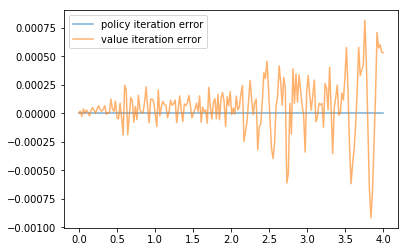

In [8]:
T, get_greedy = operator_factory(og)  # Return the Bellman operator

σ = y_grid          # Set initial condition for σ
v = og.u(y_grid)    # Set initial condition for v
sim_length = 20

for i in range(sim_length):
    σ = K(σ)  # Time iteration
    v = T(v)  # Value function iteration

# Calculate difference with actual solution
σ_error = σ_star(y_grid, α, β) - σ
v_error = σ_star(y_grid, α, β) - get_greedy(v)

plt.plot(y_grid, σ_error, alpha=0.6, label="policy iteration error")
plt.plot(y_grid, v_error, alpha=0.6, label="value iteration error")
plt.legend()
plt.show()

As you can see, time iteration is much more accurate for a given
number of iterations

## Exercises

### Exercise 1

Show that [(9)](#equation-cpi-ed-tk) is valid.  In particular,

- Let $ v $ be strictly concave and continuously differentiable on $ (0, \infty) $  
- Fix $ y \in (0, \infty) $ and show that $ MTv(y) = KMv(y) $  

### Exercise 2

Show that $ M $ is a bijection from $ \mathscr V $ to $ \mathscr P $

### Exercise 3

Consider the same model as above but with the CRRA utility function

$$
u(c) = \frac{c^{1 - \gamma} - 1}{1 - \gamma}
$$

Iterate 20 times with Bellman iteration and Euler equation time iteration

- start time iteration from $ \sigma(y) = y $  
- start value function iteration from $ v(y) = u(y) $  
- set $ \gamma = 1.5 $  


Compare the resulting policies and check that they are close

### Exercise 4

Solve the above model as we did in [the previous lecture](https://lectures.quantecon.org/py/optgrowth.html) using
the operators $ T $ and $ K $, and check the solutions are similiar by plotting

## Solutions

### Exercise 1

Let $ T, K, M, v $ and $ y $ be as stated in the exercise

Using the envelope theorem, one can show that $ (Tv)'(y) = u'(\sigma(y)) $
where $ \sigma(y) $ solves


<a id='equation-cpi-foo'></a>
$$
u'(\sigma(y))
= \beta \int v' (f(y - \sigma(y)) z ) f'(y - \sigma(y)) z \phi(dz) \tag{10}
$$

Hence $ MTv(y) = (u')^{-1} (u'(\sigma(y))) = \sigma(y) $

On the other hand, $ KMv(y) $ is the $ \sigma(y) $ that solves

$$
\begin{aligned}
    u'(\sigma(y))
    & = \beta \int (u' \circ (Mv)) (f(y - \sigma(y)) z ) f'(y - \sigma(y)) z \phi(dz)
    \\
    & = \beta \int (u' \circ ((u')^{-1} \circ v'))
        (f(y - \sigma(y)) z ) f'(y - \sigma(y)) z \phi(dz)
    \\
    & = \beta \int v'(f(y - \sigma(y)) z ) f'(y - \sigma(y)) z \phi(dz)
\end{aligned}
$$

We see that $ \sigma(y) $ is the same in each case

### Exercise 2

We need to show that $ M $ is a bijection from $ \mathscr V $ to $ \mathscr P $

To see this, first observe that, in view of our assumptions above, $ u' $ is a strictly decreasing continuous bijection from $ (0,\infty) $ to itself

It [follows](https://math.stackexchange.com/questions/672174/continuity-of-an-inverse-function) that $ h $ has the same properties

Moreover, for fixed $ v \in \mathscr V $, the derivative $ v' $ is
a continuous, strictly decreasing function

Hence, for fixed $ v \in \mathscr V $, the map $ M v = h \circ v' $
is strictly increasing and continuous, taking values in $ (0, \infty) $

Moreover, interiority holds because $ v' $ strictly dominates $ u' $, implying that

$$
(M v)(y) = h(v'(y)) < h(u'(y)) = y
$$

In particular, $ \sigma(y) := (Mv)(y) $ is an element of $ \mathscr
P $

To see that each $ \sigma \in \mathscr P $ has a preimage $ v \in \mathscr V $ with $ Mv = \sigma $, fix any $ \sigma \in \mathscr P $

Let $ v(y) := \int_0^y u'(\sigma(x)) dx $ with $ v(0) = 0 $

With a small amount of effort you will be able to show that $ v \in \mathscr V $ and $ Mv = \sigma $

It’s also true that $ M $ is one-to-one on $ \mathscr V $

To see this, suppose that  $ v $ and $ w $ are elements of $ \mathscr V $
satisfying $ Mv = Mw $

Then $ v(0) = w(0) = 0 $ and $ v' = w' $ on $ (0, \infty) $

The fundamental theorem of calculus then implies that $ v = w $ on $ \mathbb R_+ $

### Exercise 3

Here’s the code, which will execute if you’ve run all the code above

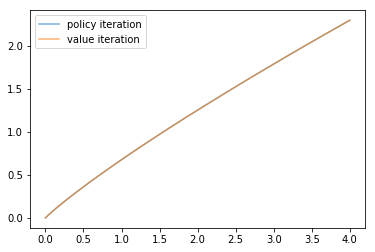

In [9]:
γ = 1.5   # Preference parameter

@njit
def u(c):
    return (c**(1 - γ) - 1) / (1 - γ)

@njit
def u_prime(c):
    return c**(-γ)

og = OptimalGrowthModel(f=f, f_prime=f_prime, u=u, u_prime=u_prime)

T, get_greedy = operator_factory(og)
K = time_operator_factory(og)

σ = y_grid        # Initial condition for σ
v = u(y_grid)     # Initial condition for v
sim_length = 20

for i in range(sim_length):
    σ = K(σ)  # Time iteration
    v = T(v)  # Value function iteration


plt.plot(y_grid, σ, alpha=0.6, label="policy iteration")
plt.plot(y_grid, get_greedy(v), alpha=0.6, label="value iteration")
plt.legend()
plt.show()

The policies are indeed close

### Exercise 4

Here’s is the function we need to solve the model using value function iteration,
copied from the previous lecture

In [10]:
def solve_model(og,
                use_parallel=True,
                tol=1e-4, 
                max_iter=1000, 
                verbose=True,
                print_skip=25): 

    T, _ = operator_factory(og, parallel_flag=use_parallel)

    # Set up loop
    v = np.log(og.y_grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return v_new

Similarly, we can write a function that uses `K` to solve the model

In [11]:
def solve_model_time(og,
                     use_parallel=True,
                     tol=1e-4,
                     max_iter=1000,
                     verbose=True,
                     print_skip=25):

    K = time_operator_factory(og, parallel_flag=use_parallel)

    # Set up loop
    σ = og.y_grid  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

Solving both models and plotting

Error at iteration 25 is 0.4046435412731171.
Error at iteration 50 is 0.14583220373327777.


Error at iteration 75 is 0.05255744743781676.
Error at iteration 100 is 0.018941531503035236.


Error at iteration 125 is 0.006826465766035739.
Error at iteration 150 is 0.0024602358498384547.


Error at iteration 175 is 0.0008866609230011591.
Error at iteration 200 is 0.0003195496856669422.


Error at iteration 225 is 0.0001151646577000065.

Converged in 229 iterations.



Converged in 10 iterations.


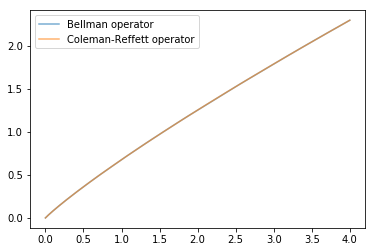

In [12]:
v_star = solve_model(og)
σ_star = solve_model_time(og)

plt.plot(y_grid, get_greedy(v_star), alpha=0.6, label='Bellman operator')
plt.plot(y_grid, σ_star, alpha=0.6, label='Coleman-Reffett operator')
plt.legend()
plt.show()

Time iteration is numerically far more accurate for a given number of iterations